In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from numpy.linalg import matrix_power
from scipy.linalg import expm, expm_frechet
import scipy
from tqdm import tqdm

In [3]:
def PauliMatrix(i):
    if i == 0:
        return np.array([[1, 0], [0, 1]])
    elif i == 1:
        return np.array([[0, 1], [1, 0]])
    elif i == 2:
        return np.array([[0, -1j], [1j, 0]])
    elif i == 3:
        return np.array([[1, 0], [0, -1]])
    else:
        raise ValueError("i must be 0, 1, 2, or 3.")

def PauliTensor(i, j):
    return np.kron(PauliMatrix(i), PauliMatrix(j))

Geometric model 

$$
    X(x) = \exp( - \tfrac{i}{2} ( \Delta \sigma_Z + \Omega \sigma_X))
$$

$$
    Y(x) = \exp( - \tfrac{i}{2} ( \Delta \sigma_Z + \Omega (\cos \phi \sigma_Y + \sin \phi \sigma_X)) )
$$

In [41]:
xpi2 = expm(-1j * np.pi / 4 * PauliMatrix(1))
ypi2 = expm(-1j * np.pi / 4 * PauliMatrix(2))
zpi2 = expm(-1j * np.pi / 4 * PauliMatrix(3))

In [180]:
for x, idx in enumerate(['a', 'b']):
    print(x, idx)

0 a
1 b


In [232]:
gate_set = {
    'I' : PauliMatrix(0),
    'X' : xpi2, 
    'Y' : ypi2,
    'Z' : zpi2
}


def circuit_to_unitary(circ, U):
    circ_unitary = np.eye(2)
    for gate in circ:
        if gate in gate_set:
            circ_unitary = gate_set[gate] @ circ_unitary
        elif gate == 'U':
            circ_unitary = U @ circ_unitary
        else:
            raise ValueError("Gate not in gate set")
    return circ_unitary

def circuit_grad_U(circ, U):
    grad = np.zeros((3, 2, 2), dtype=complex)
    # build the gradient of the circuit
    for idx, gate in enumerate(circ):
        if gate == 'U':
            grad_comp = np.array([np.eye(2)]*3, dtype=complex)
            for idx2, g in enumerate(circ):
                if idx != idx2:
                    for l in range(3):
                        if g in gate_set:
                            grad_comp[l] = gate_set[gate] @ grad_comp
                        elif g == 'U':
                            grad_comp[l] = U @ grad_comp[l]
                        else:
                            raise ValueError("Gate not in gate set")
                elif idx == idx2:
                    grad_comp[0] = -(1j/2)*PauliMatrix(1) @ U @ grad_comp[0]
                    grad_comp[1] = -(1j/2)*PauliMatrix(2) @ U @ grad_comp[1]
                    grad_comp[2] = -(1j/2)*PauliMatrix(3) @ U @ grad_comp[2]
            grad += grad_comp
    return grad


                    

    #         for i in range(3):
    #             grad[i] = gate_set[gate] @ grad[i]
    #     elif gate == 'U':
    #         grad[0] = PauliMatrix(1) @ U @ grad[0]
    #         grad[1] = PauliMatrix(2) @ U @ grad[1]
    #         grad[2] = PauliMatrix(3) @ U @ grad[2]
    #     else:
    #         raise ValueError("Gate not in gate set")
    # return grad

In [233]:
circ = 'U'

In [234]:
circuit_to_unitary(circ, xpi2)

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

In [235]:
circ_grad = circuit_grad_U(circ, xpi2)

In [236]:
circ_grad

array([[[-0.35355339+0.j        ,  0.        -0.35355339j],
        [ 0.        -0.35355339j, -0.35355339+0.j        ]],

       [[ 0.        +0.35355339j, -0.35355339+0.j        ],
        [ 0.35355339+0.j        ,  0.        -0.35355339j]],

       [[ 0.        -0.35355339j, -0.35355339+0.j        ],
        [ 0.35355339+0.j        ,  0.        +0.35355339j]]])

In [220]:
evec = 0.01*np.random.rand(3)
egen = -(1j/2)*(evec[0]*PauliMatrix(1) + evec[1]*PauliMatrix(2) + evec[2]*PauliMatrix(3))
error = expm(egen)

In [221]:
error

array([[ 9.99991403e-01-0.00354791j, -9.00182459e-04-0.00194827j],
       [ 9.00182459e-04-0.00194827j,  9.99991403e-01+0.00354791j]])

In [225]:
u_circ_error = circuit_to_unitary(circ, error@xpi2)
u_circ_target = circuit_to_unitary(circ, xpi2)
u_grad = circuit_grad_U(circ, xpi2)
linearized = evec[0]*u_grad[0] + evec[1]*u_grad[1] + evec[2]*u_grad[2]

In [230]:
expm(linearized)

array([[ 0.99861568-0.00186965j, -0.00314094-0.00137574j],
       [ 0.00314094-0.00137574j,  0.99861568+0.00186965j]])

In [231]:
error

array([[ 9.99991403e-01-0.00354791j, -9.00182459e-04-0.00194827j],
       [ 9.00182459e-04-0.00194827j,  9.99991403e-01+0.00354791j]])

In [227]:
error@xpi2 

array([[ 0.70572307-0.00187222j, -0.00314527-0.70847833j],
       [ 0.00314527-0.70847833j,  0.70572307+0.00187222j]])

In [228]:
xpi2 + linearized@xpi2

array([[ 0.70515851+0.00090019j, -0.00354792-0.70710678j],
       [ 0.00354792-0.70710678j,  0.70515851-0.00090019j]])

# circuit definition
circuit = (x1, x2, x3, x4, ..., xN)

In [7]:
def multiply_sequence(sequence):
    """Multiply a sequence of unitaries."""
    U = np.eye(2)
    for x in sequence:
        U = su2_model(x)@U
    return U


def probability(circ):
    # assume a convention where the gates go from left to right in the string
    U = multiply_sequence(circ)
    return np.abs(meas@u@prep)**2

def unitary_grad(xstate, d, circ):
    U = multiply_sequence(circ)
    grad = np.zeros(3)
    for i in range(3):
        xstate_plus = xstate.copy()
        xstate_plus[i] += d
        xstate_minus = xstate.copy()
        xstate_minus[i] -= d
        U_plus = su2_model(xstate_plus)@U
        U_minus = su2_model(xstate_minus)@U
        grad[i] = np.trace((U_plus - U_minus)/(2*d)@U.conj().T)
    return grad

def make_random_circ_def(length, prep_length=3, meas_length=3):
    germ_part = ''.join(np.random.choice(['X', 'Y'], length))
    prep_part = ''.join(np.random.choice(['X', 'Y'], prep_length))
    meas_part = ''.join(np.random.choice(['X', 'Y'], meas_length))
    return (germ_part, prep_part, meas_part)

def probability_grad_check(num_xstates=10, num_circuits=10, epsilon=1e-8, delta=1e-5):
    """Check that the gradient of the probability function is correct."""
    xstates = np.random.rand(num_xstates, 3)
    for xstate in xstates:
        for _ in range(num_circuits):
            d = np.random.randint(1, 2)
            circ_def = make_random_circ_def(np.random.randint(1, 10))
            grad = probability_grad(xstate, d, circ_def)
            dx0 = np.array([epsilon, 0, 0])
            dx1 = np.array([0, epsilon, 0])
            dx2 = np.array([0, 0, epsilon])
            prob_dx0m = probability(xstate - dx0, d, circ_def)
            prob_dx1m = probability(xstate - dx1, d, circ_def)
            prob_dx2m = probability(xstate - dx2, d, circ_def)
            prob_dx0 = probability(xstate + dx0, d, circ_def)
            prob_dx1 = probability(xstate + dx1, d, circ_def)
            prob_dx2 = probability(xstate + dx2, d, circ_def)
            grad_dx0 = (prob_dx0 - prob_dx0m)/(2*epsilon)
            grad_dx1 = (prob_dx1 - prob_dx1m)/(2*epsilon)
            grad_dx2 = (prob_dx2 - prob_dx2m)/(2*epsilon)
            assert np.allclose(grad, np.array([grad_dx0, grad_dx1, grad_dx2]), atol=delta), f"Analytic grad {grad} does not match numerical grad {np.array([grad_dx0, grad_dx1, grad_dx2])} for xstate {xstate}, d {d}, and circ_def {circ_def}."


In [8]:
probability_grad_check()

Experiment design and fisher information

Edesign is a dictionary { d : (germ, prep, meas) }

Fisher information of an edesign is the fisher information of the circuits 

$$
    [I(\theta| \mathcal{E})]_{i,j} = \sum_{n} \frac{1}{P(n|\theta, \mathcal{E})} \left( \frac{\partial }{\partial \theta_i}P(n|\theta, \mathcal{E})  \right) \left( \frac{\partial }{\partial \theta_j}P(n|\theta, \mathcal{E})  \right) 
$$

I'll use the fisher information score

$$
    S(I) = \log |I'| = \sum_j \log \lambda'_j(I)
$$
after clipping the eigenvalues to the range $[\epsilon, \infty]$ for small $\epsilon$. To score new circuits, I'll use
$$
    S(I_\text{prior tot} + I_\text{new}) - S(I_\text{prior tot})
$$

In [9]:
def edesign_probability(xstate, edesign):
    probs = dict()
    for idx, d in enumerate(edesign.keys()):
        probs[d] = []
        for circ_def in edesign[d]:
            probs[d].append( probability(xstate, d, circ_def) )
    return probs

def edesign_gradients(xstate, edesign):
    prob_grads = dict()
    for idx, d in enumerate(edesign.keys()):
        prob_grads[d] = []
        for circ_def in edesign[d]:
            prob_grads[d].append( probability_grad(xstate, d, circ_def) )
    return prob_grads

def edesign_observation(xstate, edesign, num_shots=1000):
    probs = edesign_probability(xstate, edesign)
    emperical_dists = dict()
    for d in edesign.keys():
        emperical_dists[d] = []
        for prob in probs[d]:
            emperical_dists[d].append(np.random.binomial(num_shots, prob))
    return emperical_dists

## make a Kalman filter

In [10]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

In [11]:
from filterpy.kalman import unscented_transform
from numpy import eye, zeros, dot, isscalar, outer
from copy import deepcopy

In [12]:
class KalmanFilter:
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def predict(self):
        # TODO : implmenet controls
        self.x = self.x
        self.P = self.P + self.Q

    def update(self, observation, edesign, r):
        jacobian_list = []
        prediction_list = []
        for d in edesign.keys():
            for circ_def in edesign[d]:
                jacobian = probability_grad(self.x, d, circ_def)
                prediction = probability(self.x, d, circ_def)
                jacobian_list.append(jacobian)
                prediction_list.append(prediction)
        total_jac = np.vstack(jacobian_list)
        total_pred = np.vstack(prediction_list).flatten()
        S = total_jac@self.P@total_jac.T + np.diag(r*np.ones(len(total_pred)))
        K = self.P@total_jac.T@np.linalg.inv(S)
        self.x = self.x + K@(observation - total_pred)
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)

    def iterated_update(self, observation, edesign, r, max_iter=10, tol=1e-4, return_iterations=False):
        if return_iterations:
            iterations = [self.x]
        R = np.diag(r*np.ones(len(observation))) 
        for i in range(max_iter):
            jac_list = []
            pred_list = []
            for d in edesign.keys():
                for circ_def in edesign[d]:
                    jac = probability_grad(self.x, d, circ_def)
                    pred = probability(self.x, d, circ_def)
                    jac_list.append(jac)
                    pred_list.append(pred)
            total_jac = np.vstack(jac_list)
            if tol == "R-dependent":
                tol = np.sqrt(np.trace(total_jac.T @ R @ total_jac))
            total_pred = np.vstack(pred_list).flatten()
            S = total_jac@self.P@total_jac.T + R
            K = self.P@total_jac.T@np.linalg.inv(S)
            new_x = self.x + K@(observation - total_pred)
            if return_iterations:
                iterations.append(new_x)
            update_mag = np.linalg.norm(new_x - self.x)
            self.x = new_x
            if update_mag < tol:
                break
        self.P = self.P - K@total_jac@self.P
        if hasattr(self, 'history'):
            self.history['x'].append(self.x)
            self.history['P'].append(self.P)
        if i == max_iter - 1:
            print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
        if return_iterations:
            return np.array(iterations)
        
    def plot_rms_history(self, xtrue, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        rms_history = np.zeros(len(self.history['x']))
        expected_errors = np.zeros(len(self.history['x']))
        for idx, x in enumerate(self.history['x']):
            rms_history[idx] = np.linalg.norm(x - xtrue)
            expected_errors[idx] = np.sqrt(np.trace(self.history['P'][idx]))
        ax.plot(rms_history)
        # add error bars based on expected errors
        ax.errorbar(np.arange(len(rms_history)), rms_history, yerr=expected_errors, fmt='none', ecolor='r')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('RMS Error')

    def plot_residual_history(self, xtrue, axs=None):
        # plot the theta, phi, chi resuduals against xtrue
        if axs is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        residuals = np.zeros((len(self.history['x']), 3))
        for idx, x in enumerate(self.history['x']):
            residuals[idx] = x - xtrue
        axs[0].plot(residuals[:, 0])
        axs[0].set_xlabel('Update index')
        axs[0].set_ylabel('Theta Residual')
        axs[1].plot(residuals[:, 1])
        axs[1].set_xlabel('Update index')
        axs[1].set_ylabel('Phi Residual')
        axs[2].plot(residuals[:, 2])
        axs[2].set_xlabel('Update index')
        axs[2].set_ylabel('Chi Residual')
        

In [ ]:
class MLEstimator:
    """
    using local gradient descent
    """
    def __init__(self, xinitial, Pinitial, Q=None, record_history=True) -> None:
        self.x = xinitial
        self.P = Pinitial
        if Q is None:
            self.Q = np.zeros((len(xinitial), len(xinitial)))
        else:
            self.Q = Q
        if record_history:
            self.history = {'x': [self.x], 'P': [self.P]}

    def estimate(edesign, observations, seed)

In [13]:
def fx(x, dt, u=None):
    if u is None:
        u = np.zeros(len(x))
    return x + u

def hx(x, edesign):
    return edesign_probability(x, edesign)
def vector_from_dict(d):
    # join the arrays in the dictionary into a single array
    return np.array([value for sublist in d.values() for value in sublist])

class MyUKF(UnscentedKalmanFilter):
    def __init__(self, num_params, edesign, num_shots):
        self.edesign = edesign
        self.dt=1

        # calculate number of circuits
        num_circs = 0
        for d in edesign.keys():
            num_circs += len(edesign[d])
        self.num_circs = num_circs
        self.R = (0.25/num_shots)*np.eye(num_circs)

        self.points = MerweScaledSigmaPoints(num_params, alpha=1e-3, beta=2, kappa=0)
        super().__init__(num_params, num_circs, dt=1, hx=self.hx, fx=self.fx, points=self.points)

    def fx(self, x, dt, u=None):
        if u is None:
            u = np.zeros(len(x))
        return x + u

    def hx(self, x, d):
        return np.array(edesign_probability(x, {d: self.edesign[d]})[d]).flatten()

    def check_consistency_at_d(self, d):
        """Check that the experiment design at depth d is consistent for the sigma points."""
        pass


        
    def update(self, observations, num_shots, UT=None, hx=None, max_iter=10, tol=1e-3, **hx_args):
        """
        Update the UKF with the given measurements. On return,
        self.x and self.P contain the new mean and covariance of the filter.

        update one generation at a time

        Parameters
        ----------

        z : numpy.array of shape (dim_z)
            measurement vector

        R : numpy.array((dim_z, dim_z)), optional
            Measurement noise. If provided, overrides self.R for
            this function call.

        UT : function(sigmas, Wm, Wc, noise_cov), optional
            Optional function to compute the unscented transform for the sigma
            points passed through hx. Typically the default function will
            work - you can use x_mean_fn and z_mean_fn to alter the behavior
            of the unscented transform.

        hx : callable h(x, **hx_args), optional
            Measurement function. If not provided, the default
            function passed in during construction will be used.

        **hx_args : keyword argument
            arguments to be passed into h(x) after x -> h(x, **hx_args)
        """


        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        # elif isscalar(R):
        #     R = eye(self._dim_z) * R

        for d in self.edesign.keys():
            counts = np.array(observations[d])
            z = counts/num_shots
            alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts))
            #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
            R = (0.25/num_shots)*np.eye(len(counts))

            for i in range(max_iter):
                # pass prior sigmas through h(x) to get measurement sigmas
                # the shape of sigmas_h will vary if the shape of z varies, so
                # recreate each time
                sigmas_h = []
                for s in self.sigmas_f:
                    sigmas_h.append(hx(s, d))

                self.sigmas_h = np.atleast_2d(sigmas_h)

                # mean and covariance of prediction passed through unscented transform
                zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
                self.SI = self.inv(self.S)

                # compute cross variance of the state and the measurements
                Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
                # print(self.sigmas_f, self.sigmas_h)

                # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

                self.K = dot(Pxz, self.SI)        # Kalman gain
                self.y = self.residual_z(z, zp)   # residual


                x_new = self.x + dot(self.K, self.y)
                # phase unwrapping on x[2]
                x_new[2] = np.unwrap([x_new[2]])
                if np.linalg.norm(x_new - self.x) < tol:
                    break
                else:
                    self.x = x_new
                    self.compute_process_sigmas(self.dt, self.fx)
                    #if i == max_iter - 1:
                    #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
            self.x = x_new
            self.P = self.P - self.K@self.S@self.K.T

            # save measurement and posterior state
            self.x_post = self.x.copy()
            self.z = deepcopy(z)
            self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None


    # def control_update(self, observations, num_shots, UT=None, hx=None, max_iter=10, tol=1e-3, **hx_args):
    #     """
    #     Update the UKF with the given measurements. On return,
    #     self.x and self.P contain the new mean and covariance of the filter.

    #     update one generation at a time

    #     Parameters
    #     ----------

    #     z : numpy.array of shape (dim_z)
    #         measurement vector

    #     R : numpy.array((dim_z, dim_z)), optional
    #         Measurement noise. If provided, overrides self.R for
    #         this function call.

    #     UT : function(sigmas, Wm, Wc, noise_cov), optional
    #         Optional function to compute the unscented transform for the sigma
    #         points passed through hx. Typically the default function will
    #         work - you can use x_mean_fn and z_mean_fn to alter the behavior
    #         of the unscented transform.

    #     hx : callable h(x, **hx_args), optional
    #         Measurement function. If not provided, the default
    #         function passed in during construction will be used.

    #     **hx_args : keyword argument
    #         arguments to be passed into h(x) after x -> h(x, **hx_args)
    #     """


    #     if hx is None:
    #         hx = self.hx

    #     if UT is None:
    #         UT = unscented_transform

    #     # elif isscalar(R):
    #     #     R = eye(self._dim_z) * R

    #     for d in self.edesign.keys():
    #         counts = np.array(observations[d])
    #         z = counts/num_shots
    #         alpha_vec = (counts + np.ones(len(counts)))/(num_shots + len(counts))
    #         #R = np.diag(alpha_vec*(1-alpha_vec)/(num_shots + len(counts) +1))
    #         R = (0.25/num_shots)*np.eye(len(counts))

    #         for i in range(max_iter):
    #             # pass prior sigmas through h(x) to get measurement sigmas
    #             # the shape of sigmas_h will vary if the shape of z varies, so
    #             # recreate each time
    #             sigmas_h = []
    #             for s in self.sigmas_f:
    #                 sigmas_h.append(hx(s, d))

    #             self.sigmas_h = np.atleast_2d(sigmas_h)

    #             # mean and covariance of prediction passed through unscented transform
    #             zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc, R, self.z_mean, self.residual_z)
    #             self.SI = self.inv(self.S)

    #             # compute cross variance of the state and the measurements
    #             Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)
    #             # print(self.sigmas_f, self.sigmas_h)

    #             # print(np.linalg.norm(Pxz), np.linalg.norm(self.S), np.linalg.norm(self.SI))

    #             self.K = dot(Pxz, self.SI)        # Kalman gain
    #             self.y = self.residual_z(z, zp)   # residual


    #             u = -dot(self.K, self.y)
    #             x_new = self.x + dot(self.K, self.y)
    #             # phase unwrapping on x[2]
    #             if np.linalg.norm(x_new - self.x) < tol:
    #                 break
    #             else:
    #                 self.x = x_new
    #                 self.update()
    #                 #if i == max_iter - 1:
    #                 #    print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
    #         self.x = x_new
    #         self.P = self.P - self.K@self.S@self.K.T

    #         # save measurement and posterior state
    #         self.x_post = self.x.copy()
    #         self.z = deepcopy(z)
    #         self.P_post = self.P.copy()

        
    #     # set to None to force recompute
    #     self._log_likelihood = None
    #     self._likelihood = None
    #     self._mahalanobis = None
    #     u = - self.x 
    #     self.x = np.zeros(len(self.x))
    #     return u


## Circuit selection

In [14]:
def fisher_information_matrix(xstate, edesign):
    ed_probs = edesign_probability(xstate, edesign)
    ed_grads = edesign_gradients(xstate, edesign)
    probs = [value for sublist in ed_probs.values() for value in sublist]
    grads = [value for sublist in ed_grads.values() for value in sublist]
    fisher_info = np.zeros((len(xstate), len(xstate)))
    for idx, p in enumerate(probs):
        if p == 0:
            fisher_info += np.zeros((len(xstate), len(xstate)))
        else:
            fisher_info += np.outer(grads[idx], grads[idx])/p
    return fisher_info

def score_fisher_information_matrix(fmat, clip=1e-19):
    evals = np.linalg.eigvals(fmat)
    # clip 
    evals = np.clip(evals, clip, float('inf'))
    if np.any(evals <= 0):
        print(evals, np.clip(evals, clip, np.max(evals)))
    return np.sum(np.log(evals))

In [15]:
def find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list):
    """Find the minimal circuits for a fixed depth."""
    all_circuits = dict()
    for germ in germ_list:
        for prep in prep_list:
            for meas in meas_list:
                all_circuits[(germ, prep, meas)] = prep + germ*d + meas
    
    minimal_circuits = []
    total_fisher_info = np.zeros((len(xestimate), len(xestimate)))
    for r in range(num_circs):
        scores = {}
        for circ_def, circ in all_circuits.items():
            if circ_def in minimal_circuits:
                continue
            I_circ = fisher_information_matrix(xestimate, {d: [circ_def]})
            new_fisher = total_fisher_info + I_circ
            score = score_fisher_information_matrix(new_fisher) 
            scores[circ_def] = score
        best_circ_def = max(scores, key=scores.get)
        minimal_circuits.append(best_circ_def)
        total_fisher_info += fisher_information_matrix(xestimate, {d: [best_circ_def]})
    if np.linalg.matrix_rank(total_fisher_info) < len(xestimate):
        Warning( np.linalg.matrix_rank(total_fisher_info) )
    return minimal_circuits

In [16]:
all_state_preps = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
all_measurements = ['', 'Y', 'YY', 'YYY', 'X', 'XXX']
germ_list = ['X', 'Y', 'XX', 'YY', 'XY', 'XXY', 'XYX']

reduced_germ_list = ['X', 'Y', 'XY']
reduced_state_preps = ['', 'X']
reduced_measurements = ['YYY', 'XXX']

In [17]:
def make_complete_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = []
        for prep in all_state_preps:
            for germ in germ_list:
                for meas in all_measurements:
                    edesign[d].append((germ*d, prep, meas))
    return edesign

def make_minimal_experiment_design(xestimate, depths, num_circs, germ_list, prep_list, meas_list):
    edesign = {}
    for d in depths:
        edesign[d] = find_minimial_circuits_fixed_depth(xestimate, d, num_circs, germ_list, prep_list, meas_list)
    return edesign

def make_reduced_edeisgn(depths):
    reduced_edesign = {}
    for d in depths:
        reduced_edesign[d] = []
        for prep in all_state_preps:
            for germ in reduced_germ_list:
                for meas in all_measurements:
                    reduced_edesign[d].append((germ*d, prep, meas))
    return reduced_edesign

In [18]:
custom_circuit_list = [
    ('X', '', ''), 
    ('X', '', 'X'), 
    ('Y', '', ''), 
    ('Y', '', 'Y'), 
    ('XX', 'X', ''),
    ('XX', 'X', 'X'),
    ('XYX', '', ''),
    ('XYX', '', 'X')
]

def make_custom_experiment_design(depths):
    edesign = {}
    for d in depths:
        edesign[d] = custom_circuit_list
    return edesign

## Evaluating fisher information

In [19]:
depths = [1, 2, 4, 8, 16, 32]

In [20]:
edesign_complete = make_complete_experiment_design(depths)

In [21]:
target_state = np.array([0, 0, 0])
covar = 0.01
true_state = target_state + np.random.normal(0, covar, 3)

In [22]:
edesign_mini = make_minimal_experiment_design(true_state, depths, 10, germ_list, all_state_preps, all_measurements)

In [23]:
edesign_mini 

{1: [('XXY', 'X', 'XXX'),
  ('YY', 'YYY', 'Y'),
  ('XYX', 'XXX', 'Y'),
  ('XYX', 'X', 'YYY'),
  ('XYX', 'YYY', 'X'),
  ('X', 'XXX', 'XXX'),
  ('XYX', 'Y', 'YYY'),
  ('XY', 'YY', 'XXX'),
  ('YY', 'YYY', 'YY'),
  ('XYX', 'YYY', 'Y')],
 2: [('XY', 'YY', 'Y'),
  ('XY', 'Y', 'XXX'),
  ('YY', 'YYY', 'YYY'),
  ('XY', 'X', 'YY'),
  ('XXY', 'XXX', 'XXX'),
  ('XX', 'XXX', 'XXX'),
  ('XXY', '', 'YY'),
  ('XYX', 'YY', ''),
  ('XXY', 'Y', 'Y'),
  ('XY', '', 'YYY')],
 4: [('XYX', '', 'YYY'),
  ('YY', 'YY', 'YYY'),
  ('XY', 'Y', ''),
  ('XXY', 'XXX', 'XXX'),
  ('XX', 'XXX', 'XXX'),
  ('XY', 'YY', 'XXX'),
  ('XYX', '', 'YY'),
  ('YY', 'YYY', 'YYY'),
  ('XXY', 'X', 'X'),
  ('XYX', 'YY', '')],
 8: [('XXY', 'Y', 'Y'),
  ('XX', 'YY', ''),
  ('XX', '', 'YY'),
  ('XXY', 'XXX', 'XXX'),
  ('XX', 'XXX', 'XXX'),
  ('XYX', '', 'YY'),
  ('XY', 'XXX', ''),
  ('YY', 'YYY', 'YYY'),
  ('XXY', 'YYY', 'XXX'),
  ('XXY', 'X', 'X')],
 16: [('XXY', 'Y', 'XXX'),
  ('YY', 'YYY', 'YYY'),
  ('XX', '', 'YY'),
  ('XXY', 'XXX', '

In [24]:
minimal_fisher_info = fisher_information_matrix(true_state, edesign_mini)

In [25]:
complete_fisher_info = fisher_information_matrix(true_state, edesign_complete)

In [26]:
np.linalg.eigvals(minimal_fisher_info)

array([42004.44255004,    67.23794642,  6729.91193664])

In [27]:
np.linalg.eigvals(minimal_fisher_info)

array([42004.44255004,    67.23794642,  6729.91193664])

In [28]:
minimial_fisher_score = np.sum(np.log(np.linalg.eigvals(minimal_fisher_info)))
complete_fisher_score = np.sum(np.log(np.linalg.eigvals(complete_fisher_info)))
print('minimal score ', minimial_fisher_score)
print('complete score ', complete_fisher_score)

minimal score  23.66808577110517
complete score  42.246809380391326


In [29]:
true_state = np.array([0, 0, 0])
covar = 0.1
x0 = true_state + np.random.normal(0, covar, 3)
P0 = np.eye(3)*covar
num_shots = 1000

In [30]:
#ekf = KalmanFilter(x0, P0, record_history=True)

In [31]:
ukf = MyUKF(3, edesign_mini, num_shots)
ukf.x = x0
ukf.P = P0
ukf.R = (0.25/num_shots)*np.eye(ukf.num_circs)

In [32]:
observations = edesign_observation(true_state, edesign_mini, num_shots)

In [33]:
ukf.predict()
ukf.update(observations, num_shots, tol=1e-4)


In [34]:
#ekf.iterated_update(observations, edesign, 0.25/num_shots)

In [35]:
# original error
np.linalg.norm(x0 - true_state)

0.11869423842103416

In [36]:
# ekf error
#np.linalg.norm(ekf.x - true_state)

In [37]:
# ukf error
np.linalg.norm(ukf.x - true_state)

0.0007465785872364579

## tomographic estimation under oscillations in parameters

In [61]:
target_state = np.array([0, 0, 0])

In [73]:
reduced_edesign = make_reduced_edeisgn(depths)

In [65]:
depths = [1, 2, 4, 8]
edesign = make_minimal_experiment_design(target_state, depths, 10, germ_list, all_state_preps, all_measurements)

In [77]:
Q = np.eye(3)*0.0001
covar = 0.000000000001
P0 = np.eye(3)*covar


In [78]:
num_steps = 100
num_iterations = 10
tol = 1e-4

In [79]:
osc_freq = 1/8

In [81]:
true_state = target_state + np.random.multivariate_normal(np.zeros(3), P0)

experiment_design = reduced_edesign

#ekf = KalmanFilter(x0, P0, Q=Q, record_history=True)
ukf = MyUKF(3, experiment_design, num_shots)
x0 = target_state
ukf.x = x0
ukf.P = P0
ukf.Q = Q

ukf_history = []
ekf_history = []
true_state_history = []
for i in tqdm(range(num_steps)):
    w = 0.1*np.array([np.cos(2*np.pi*osc_freq*i), 0, 0])
    true_state = true_state + w
    true_state_history.append(true_state)
    observations = edesign_observation(true_state, experiment_design, num_shots)
    ukf.predict(u=np.zeros(3))
    ukf.update(observations, num_shots, max_iter=5,tol=1e-5)
    ukf_history.append(ukf.x)
    # ekf.predict()
    # ekf.iterated_update(observations, edesign, 0.25/num_shots)
    #ekf_history.append(ekf.x)

 27%|██▋       | 27/100 [01:53<05:05,  4.19s/it]


KeyboardInterrupt: 

In [75]:
ukf_history = np.array(ukf_history)
#ekf_history = np.array(ekf_history)
true_state_history = np.array(true_state_history)

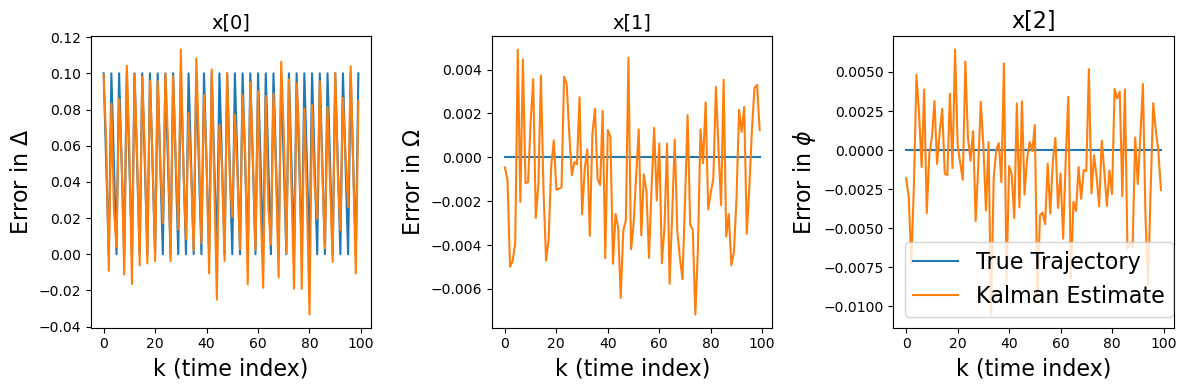

In [76]:
# plot the estimated and true state over time
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(true_state_history[:, 0], label='True Trajectory')
ax[0].plot(ukf_history[:, 0], label='Kalman Estimate')
#ax[0].plot(ekf_history[:, 0], label='EKF')


font_size = 16
ax[0].set_xlabel('k (time index)', fontsize=font_size)
ax[0].set_ylabel('Error in $\\Delta$', fontsize=font_size)
ax[0].set_title('x[0]', fontsize=14)
ax[1].plot(true_state_history[:, 1], label='True Trajectory')
ax[1].plot(ukf_history[:, 1], label='Kalman Estimate')
#ax[1].plot(ekf_history[:, 1], label='EKF')
ax[1].set_xlabel('k (time index)', fontsize=font_size)
ax[1].set_ylabel('Error in $\\Omega$', fontsize=font_size)
ax[1].set_title('x[1]', fontsize=14)
ax[2].plot(true_state_history[:, 2], label='True Trajectory')
ax[2].plot(ukf_history[:, 2], label='Kalman Estimate')
ax[2].set_xlabel('k (time index)', fontsize=font_size)
ax[2].set_ylabel('Error in $\\phi$', fontsize=font_size)
ax[2].set_title('x[2]', fontsize=font_size)
# make the font larger for the labels



ax[2].legend(fontsize=font_size)
# set tight layout
plt.tight_layout()


(xestimate, depths, num_circs, germ_list, prep_list, meas_list)